# Time to get your hands dirty! Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at [https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt](https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt)
- You can find the physical meaning of each variable at [https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html](https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html)

This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the techniques we have seen in classes so far, etc. **Be creative! You're discovering**

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?


In [12]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import silhouette_score

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

/tmp/ipykernel_1007/3291602058.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [3]:
# Extract numerical arrays for T90 duration, its error, fluence, fluence error, and redshift from the dataset
T90=np.array(data[6],dtype=float)
T90err=np.array(data[7],dtype=float)
fluence=np.array(data[9],dtype=float)
fluencererr=np.array(data[10],dtype=float)
redshift = np.array(data[11], dtype=float)
print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [ ]:
datanew = np.column_stack((T90, fluence)) # Create a new dataset with T90 and fluence values
mask = ~(datanew == -999).any(axis=1) # Create a boolean mask that identifies rows which do NOT contain the value -999

datanew_c = datanew[mask] # Apply the mask to keep only the valid rows (those without -999)
print(datanew_c.shape)


(7503, 2)


In [ ]:
# Create a boolean mask to select rows where both T90 and fluence are greater than 0 ( in order to apply logarithm)
valid_mask = (datanew_c[:, 0] > 0) & (datanew_c[:, 1] > 0)
T90log = np.log10(datanew_c[:, 0][valid_mask])  
Fluencelog = np.log10(datanew_c[:, 1][valid_mask])  

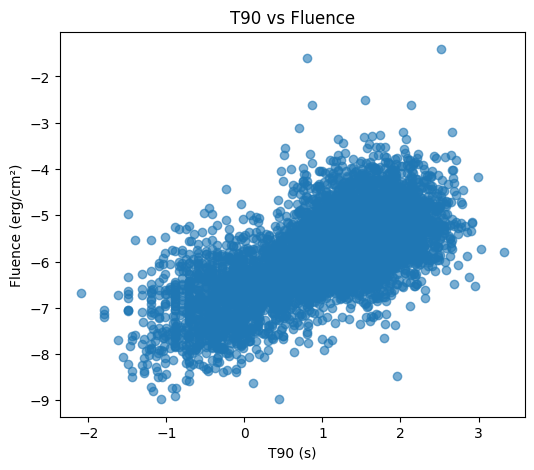

In [6]:
plt.figure(figsize=(6,5))
plt.scatter(T90log, Fluencelog, alpha=0.6)
plt.xlabel("T90 (s)")
plt.ylabel("Fluence (erg/cm²)")
plt.title("T90 vs Fluence")
plt.show()


Text(0.5, 1.0, 'Distribution of T90log')

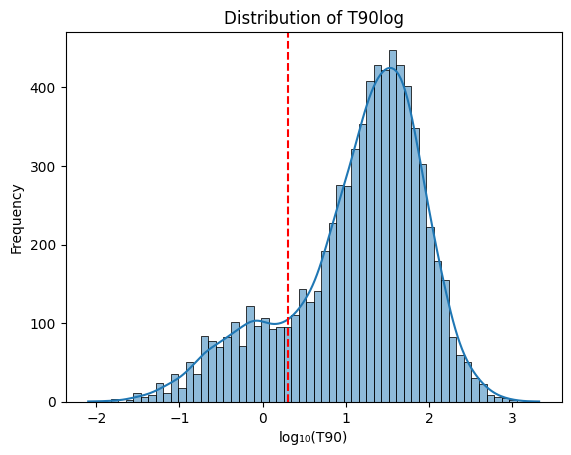

In [9]:
sns.histplot(T90log, bins=60, kde=True, edgecolor='black')
plt.axvline(np.log10(2), color='red', linestyle='--', label='T90=2s') # This line represents the division between long and short Gamma Ray Bursts
plt.xlabel('log₁₀(T90)')
plt.ylabel('Frequency')
plt.title('Distribution of T90log')

Text(0.5, 1.0, 'Distribution of Fluencelog')

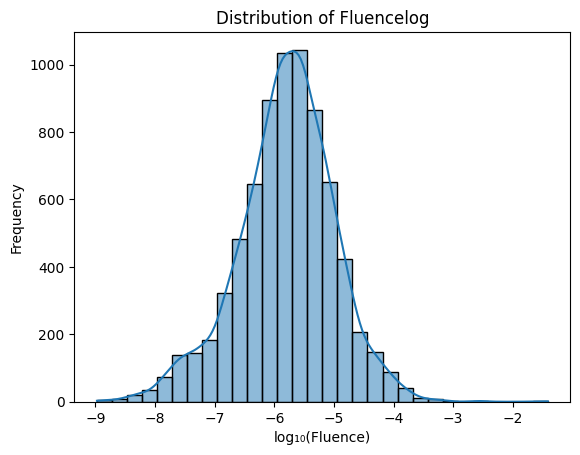

In [8]:
sns.histplot(Fluencelog, bins=30, kde=True, edgecolor='black')
plt.xlabel('log₁₀(Fluence)')
plt.ylabel('Frequency')
plt.title('Distribution of Fluencelog')

In [10]:
X = np.column_stack((T90log, Fluencelog))
clf = KMeans(n_clusters=2,n_init='auto') # Initialize the KMeans clustering model with 2 cluster
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X)  #labels for each of the points

Text(0.5, 1.0, 'Clustering output')

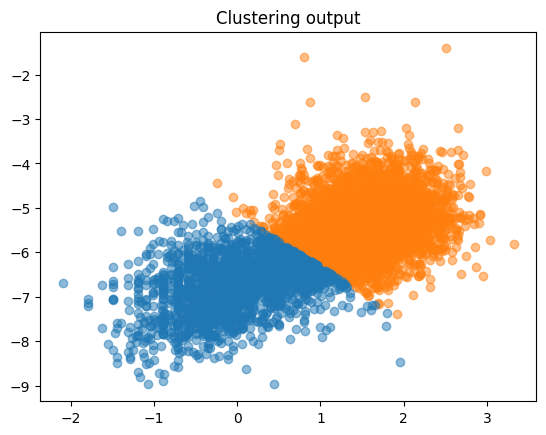

In [ ]:
# Plot the data points color-coded by their assigned cluster
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output')

In [ ]:
# Calculate the silhouette score for KMeans clustering with varying numbers of clusters
for n_clusters in range(2, 7):
    clf = KMeans(n_clusters=n_clusters, n_init='auto')
    clf.fit(X)
    sil_score = silhouette_score(X, labels)
    

    print(f"\nSilhouette Score per {n_clusters} cluster: {sil_score}")


Silhouette Score per 2 cluster: 0.3237593544096005

Silhouette Score per 3 cluster: 0.3237593544096005

Silhouette Score per 4 cluster: 0.3237593544096005

Silhouette Score per 5 cluster: 0.3237593544096005

Silhouette Score per 6 cluster: 0.3237593544096005


In [ ]:
X = np.column_stack((T90log, Fluencelog))
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
bandwidth_value = 1.9
ms = MeanShift(bandwidth=bandwidth_value, bin_seeding=True, cluster_all=False) # Initialize and fit the MeanShift model
ms.fit(X_scaled)

labels_ms = ms.labels_  # Get the labels assigned to each data point
centers_ms = ms.cluster_centers_  # Get the coordinates of the cluster centers


Text(0.5, 1.0, 'Mean-Shift Clustering: T90 vs Fluence (scaled) - Bandwidth 1.9')

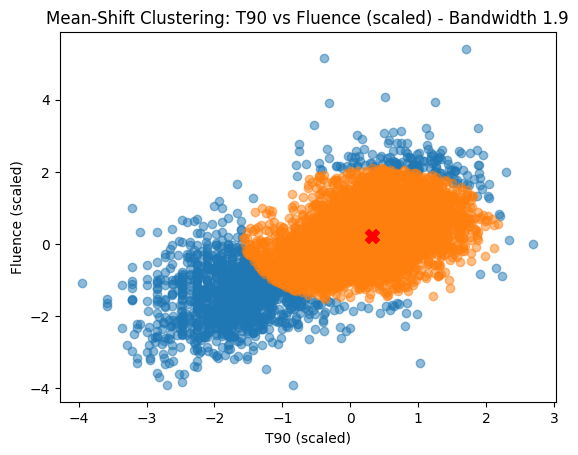

In [ ]:
unique_labels = np.unique(labels_ms) # Get the unique cluster labels

# Scatter plot the points of each cluster, using a different color for each cluster
for label in unique_labels:
    plt.scatter(X_scaled[labels_ms == label, 0], X_scaled[labels_ms == label, 1], 
                alpha=0.5, label=f'Cluster {label+1}')

# Plot the centers of the clusters
plt.scatter(centers_ms[:, 0], centers_ms[:, 1], s=100, c='red', marker='X', label='Cluster Centers')

plt.xlabel('T90 (scaled)')
plt.ylabel('Fluence (scaled)')
plt.title(f"Mean-Shift Clustering: T90 vs Fluence (scaled) - Bandwidth {bandwidth_value}")

In [ ]:
# Apply MeanShift clustering with varying bandwidth values to compute the silhouette score for each bandwidth.
for i in range(1, 20):  
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    bandwidth_value = i / 10
    ms = MeanShift(bandwidth=bandwidth_value, bin_seeding=True, cluster_all=False)
    ms.fit(X_scaled)

    labels_ms = ms.labels_
    centers_ms = ms.cluster_centers_

     # If more than one cluster is found, calculate the silhouette score
    if len(np.unique(labels_ms)) > 1:
        sil_score = silhouette_score(X_scaled, labels_ms)
        print(f"\nSilhouette Score for bandwidth {bandwidth_value:.1f}: {sil_score:.3f}")
    else:
        print(f"\nBandwidth {bandwidth_value:.1f}: Only one cluster, Silhouette Score not defined.")

    
    


Silhouette Score for bandwidth 0.1: 0.176

Silhouette Score for bandwidth 0.2: -0.122

Silhouette Score for bandwidth 0.3: -0.255

Silhouette Score for bandwidth 0.4: -0.232

Silhouette Score for bandwidth 0.5: -0.138

Silhouette Score for bandwidth 0.6: -0.024

Silhouette Score for bandwidth 0.7: 0.088

Silhouette Score for bandwidth 0.8: 0.152

Silhouette Score for bandwidth 0.9: 0.217

Silhouette Score for bandwidth 1.0: 0.275

Silhouette Score for bandwidth 1.1: 0.325

Silhouette Score for bandwidth 1.2: 0.364

Silhouette Score for bandwidth 1.3: 0.405

Silhouette Score for bandwidth 1.4: 0.432

Silhouette Score for bandwidth 1.5: 0.455

Silhouette Score for bandwidth 1.6: 0.473

Silhouette Score for bandwidth 1.7: 0.487

Silhouette Score for bandwidth 1.8: 0.499

Silhouette Score for bandwidth 1.9: 0.506
